# MTH448 Project 4
## Sean Huber

## Introduction


In Report 4, our goal is to develop a code that cleverly identifies celestial objects—such as stars, galaxies, and quasars (QSOs)—in a photograph of a specific area of the sky. The challenge here is dealing with the unknowns: we don’t have clear information on which way the camera was pointing, its tilt, or how much of the sky it was zoomed in on. This project was hard to understand and difficult to execute.

In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

thumbnail_w = 2.0 # cm
thumbnail_h = 1.5 # cm
arms_length = 65  # cm

w_degrees = thumbnail_w/arms_length * 180/np.pi
h_degrees = thumbnail_h/arms_length * 180/np.pi

phi0_hours = .15
phi0_degrees   = phi0_hours * 360/24 
theta0_degrees = 32                  

delta_phi_degrees = w_degrees/np.cos( theta0_degrees * np.pi/180 )
delta_theta_degrees = h_degrees

phi1_degrees   = phi0_degrees + delta_phi_degrees
theta1_degrees = theta0_degrees + delta_theta_degrees

print('ra:',phi0_degrees,delta_phi_degrees,phi1_degrees)
print('dec:',theta0_degrees,delta_theta_degrees,theta1_degrees)

q = f'''SELECT TOP 500000
        p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z,
        s.specobjid, s.class, s.z as redshift
FROM PhotoObj AS p
        JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE
        p.ra between {phi0_degrees} and {phi1_degrees} and
        p.dec between {theta0_degrees} and {theta1_degrees}
'''
url = 'http://skyserver.sdss.org/dr18/SkyServerWS/SearchTools/SqlSearch?cmd={}&format=csv'.format(q.replace(' ','%20'))
r = requests.get(url)
if r.status_code==200:
         csv = StringIO(r.text)
         df = pd.read_csv(csv,skiprows=1)
         display(df)
else:
         print('Unsuccessful :-(')


ra: 2.25 2.078829101711481 4.328829101711481
dec: 32 1.322210296455746 33.322210296455744


,objid,ra,dec,u,g,r,i,z,specobjid,class,redshift
0,1237680310693528074,3.123755,32.090136,25.92454,22.02408,20.78240,19.84559,19.49351,8024546856582535168,GALAXY,0.609470
1,1237680310693658891,3.524279,32.166552,25.76373,21.28277,19.44916,18.68740,18.41707,8026636203603548160,GALAXY,0.448114
2,1237680311230333340,3.019134,32.509953,20.54846,20.08710,19.92196,19.63757,19.55872,8723472893957396480,QSO,0.621798
3,1237680311230333709,2.985866,32.485793,23.20275,21.05684,20.82736,20.64299,21.08188,8026699975277959168,STAR,-0.000538
4,1237680311230398964,3.222362,32.694096,21.13175,20.57648,20.55289,20.22832,20.17862,8720298873413982208,QSO,0.539252
...,...,...,...,...,...,...,...,...,...,...,...
908,1237680478194369425,3.100708,32.411503,23.07704,20.90564,20.39170,20.26201,20.02817,8720290077320960000,STAR,-0.000485
909,1237680478194369636,3.082479,32.358187,24.58443,23.24409,21.93220,20.82331,19.76565,8720289252687239168,GALAXY,0.555901
910,1237680479267915032,2.512164,33.124797,22.42771,25.93316,23.09697,21.08679,19.79784,8723729080166668288,GALAXY,0.737840
911,1237680479268176951,3.231195,33.184110,23.16306,24.38149,21.53329,20.12610,19.28092,8723746672352712704,GALAXY,0.778379



This script calculates the field of view in degrees for a given thumbnail size held at arm's length, then uses these calculations to define a rectangular area of the sky in terms of right ascension (RA) and declination (Dec). It constructs and executes a SQL query to fetch data for up to 500,000 astronomical objects within this area from the Sloan Digital Sky Survey (SDSS) database. The query selects objects based on their coordinates, photometric measurements (u, g, r, i, z), and spectroscopic data (object ID, class, redshift), joining information from the PhotoObj and SpecObj tables. If the query is successful, it displays the data in a Pandas DataFrame; otherwise, it indicates failure. This process demonstrates the application of Python in querying and analyzing astronomical data, specifically for objects within a specified region of the sky.

### Select just the 50 or so (or fewer?) brightest objects in the patch

Selected 106 brightest objects in patch


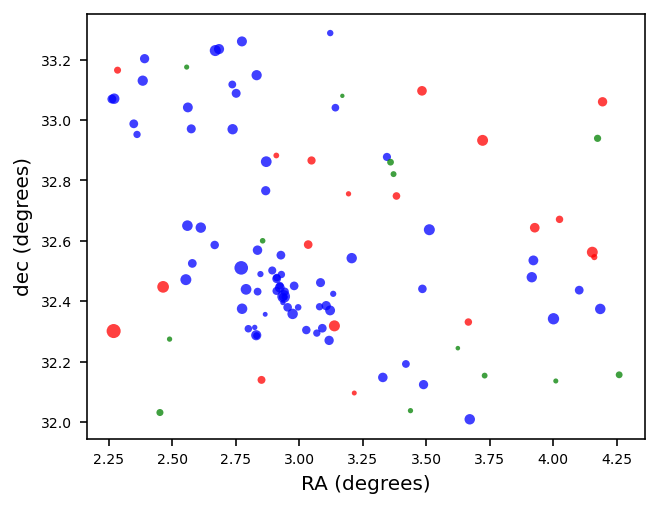

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

df['brightness'] = (df['g'].max()-df['g'])/(df['g'].max()-df['g'].min())  # makes dimmest=0 and brightest=1
brightness_threshold = .7
dfb = df[ df['brightness']>brightness_threshold ].copy()  # select just the brightest objects
print('Selected',len(dfb),'brightest objects in patch' )
decref = (theta0_degrees + theta1_degrees)/2  # representative declination for my patch
plt.figure(figsize=(5,5))
plt.subplot(111,aspect=1/np.cos(decref*np.pi/180))
for kind,color in zip(['GALAXY','QSO','STAR'],'bgr'):
    dfx = dfb[ dfb['class']==kind ]
    sizes = 150*(dfx['brightness']-brightness_threshold+.03) # make sizes vary a lot for visual interest
    plt.scatter( dfx['ra'], dfx['dec'],c=color, s=sizes, alpha=0.75, linewidth=0 )
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')

#Do the projection on to the tangent plane
dec0 = 10.75  # representative declination for the patch
dfb['x'] = dfb['ra']/np.cos(dec0*np.pi/180)
dfb['y'] = dfb['dec']


This code snippet is designed for analyzing and visualizing the brightest celestial objects in a given patch of the sky, based on data that includes right ascension, declination, and 'g' band magnitudes. It starts by enhancing figure quality for high-resolution displays. Then, it calculates and normalizes the brightness of each object, creating a scale where 0 represents the dimmest and 1 the brightest. Only objects surpassing a brightness threshold are selected for further analysis. The visualization plots these objects, distinguishing galaxies, quasars, and stars by color, and adjusts their size based on brightness for visual clarity. The plot is carefully adjusted for spatial accuracy by correcting for the spherical distortion through a projection on the tangent plane, based on a representative declination. This approach allows for a detailed and accurate visual representation of the most luminous objects within the targeted sky segment, facilitating a better understanding of their spatial distribution and characteristics.

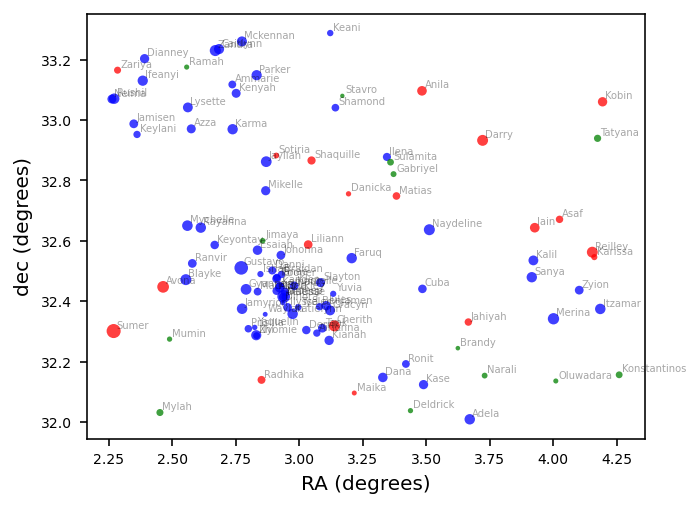

In [3]:
# Get some random nicknames to use instead of the unfriendly objids
# Idea: use person first names from SSA list
namelist = pd.read_csv('yob2008.txt',header=None)[0].values
dfb['nickname']= namelist[np.random.choice(list(range(len(namelist))),len(dfb),replace=False)]

plt.figure(figsize=(5,5))
plt.subplot(111,aspect=1/np.cos(decref*np.pi/180))
for kind,color in zip(['GALAXY','QSO','STAR'],'bgr'):
    dfx = dfb[ dfb['class']==kind ]
    sizes = 150*(dfx['brightness']-brightness_threshold+.03) # make sizes vary quite a lot for visual interest
    plt.scatter( dfx['ra'], dfx['dec'],c=color, s=sizes, alpha=0.75, linewidth=0 )
offset = .01
for ra,dec,nickname in dfb[['ra','dec','nickname']].values:
    plt.text(ra+offset,dec+offset,nickname,fontsize=5,alpha=0.35)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)');

star_catalog = dfb


This code enhances the analysis of bright celestial objects by assigning them nicknames from a list, transforming technical data into a more accessible and engaging format. It uses a visualization technique to plot these objects—categorized as galaxies, quasars, and stars—with distinct colors and sizes that reflect their brightness. Each object is labeled with its new "nickname" on the plot, making them easier to identify and discuss. The plot is carefully adjusted to account for spherical distortion, ensuring an accurate spatial representation. This approach not only makes the data analysis more intuitive by using familiar names but also enriches the visual presentation, making the exploration of celestial objects in a specific sky segment both informative and captivating. The resulting star_catalog DataFrame serves as a unique catalog of these objects, bridging the gap between astronomical data and human engagement.

In [4]:
display(star_catalog.head(5))

,objid,ra,dec,u,g,r,i,z,specobjid,class,redshift,brightness,x,y,nickname
6,1237680311230726265,4.153093,32.562343,18.24992,17.20397,16.85479,16.72338,16.65458,8720347251925604352,STAR,-0.000364,0.868038,4.227280,32.562343,Reilley
24,1237680311230267543,2.855879,32.600088,19.56717,18.73295,18.69255,18.63079,18.56880,8024541084146489344,QSO,2.702766,0.722326,2.906894,32.600088,Jimaya
29,1237680311766941982,2.262658,33.069555,19.80747,17.88671,16.84491,16.38800,16.01532,8023241461436012544,GALAXY,0.110743,0.802972,2.303076,33.069555,Neima
35,1237680478194303420,2.911476,32.478284,20.40532,18.28953,17.34453,16.98567,16.65065,8026688980161681408,GALAXY,0.104801,0.764584,2.963484,32.478284,Tanae
48,1237680479268045052,2.832249,33.148687,19.56345,17.45263,16.39170,15.92693,15.53951,8026696126987261952,GALAXY,0.114372,0.844340,2.882842,33.148687,Parker


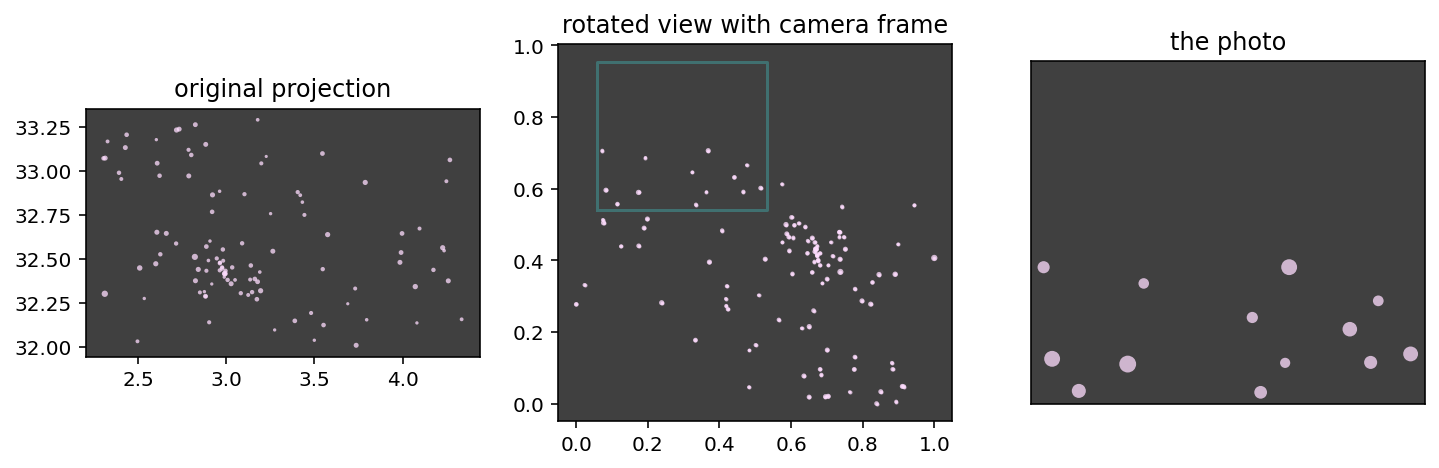

In [5]:
def take_photo(starprojection_in):

    def random(lo,hi):
        return lo + (hi-lo)*np.random.rand()
    
    starprojection = starprojection_in.copy()
    starprojection['brightness'] -= starprojection['brightness'].min()
    starprojection['brightness'] += .1
    starprojection['brightness'] /= starprojection['brightness'].max()
    
    sp = starprojection[['x','y']].values
    plt.figure(figsize=(12,4))
    plt.subplot(131,aspect=1,facecolor='#404040')
    plt.scatter(sp[:,0],sp[:,1],c='#ffddff', s=10*starprojection['brightness'], alpha=0.75, linewidth=0 )
    plt.title('original projection')
    
    sp -= sp.min(axis=0)
    sp /= sp.max()
    # data now lies in unit square
    
    theta = 2*np.pi*np.random.rand()  # choose a rotation angle
    c,s = np.cos(theta),np.sin(theta)
    rotation = np.array([[c,-s],[s,c]])
    rsp = (np.dot(rotation,sp.T)).T
    # scale to unit square again
    rsp -= rsp.min(axis=0)
    rsp /= rsp.max()
        
    w = random(.2,.6)
    xlo = random(0,1-w)
    xhi = xlo + w
    h = random(.15,.5)
    ylo = random(0,1-h)
    yhi = ylo + h
    plt.subplot(132,aspect=1,facecolor='#404040')
    plt.plot(rsp[:,0],rsp[:,1],'o',color='#ffddff',markersize=1,alpha=0.7)
    plt.scatter(rsp[:,0],rsp[:,1],c='#ffddff', s=10*starprojection['brightness'], alpha=0.75, linewidth=0 )
    box = np.array([[xlo,xhi,xhi,xlo,xlo],[ylo,ylo,yhi,yhi,ylo]])
    plt.plot(*box,'#40a0a0',alpha=0.5)
    plt.title('rotated view with camera frame')
    
    starprojection['xprime'] = rsp[:,0]
    starprojection['yprime'] = rsp[:,1]
    
    photo = starprojection[ (starprojection['xprime']>=xlo) & \
                            (starprojection['xprime']<=xhi) & \
                            (starprojection['yprime']>=ylo) & \
                            (starprojection['yprime']<=yhi) ]
    plt.subplot(133,aspect=1,facecolor='#404040')
    plt.scatter(photo['xprime'],photo['yprime'],c='#ffddff', s=100*photo['brightness'], alpha=0.75, linewidth=0 )
    plt.xlim(xlo,xhi)
    plt.ylim(ylo,yhi)
    plt.xticks([])
    plt.yticks([])
    plt.title('the photo')
    #plt.axis('off')
    photo = photo.rename(columns={'nickname':'nickname for checking answers','brightness':'brightness for plotting only'})
    return photo[['xprime','yprime','nickname for checking answers','brightness for plotting only']].reset_index(drop=True)#,'brightness']]
      
photo = take_photo(dfb)


The take_photo function simulates the process of capturing a photograph of celestial objects within a specific sky segment, starting with normalizing their brightness for visual clarity. It visually plots the original positions of these objects, then applies a random rotation and zoom to mimic the varied perspectives from which a camera might capture this segment of the sky. The function selects a subset of these objects based on a randomly generated camera frame, visualizing both the adjusted orientation and the final "photo" that includes only the objects within this frame. The resulting photo is presented in a DataFrame, showcasing the positions, nicknames, and adjusted brightness of the captured celestial bodies, prepared specifically for analysis and visualization. This approach offers a dynamic method for understanding how different viewing angles and fields of view can affect the observation of astronomical objects.

In [6]:
display(photo)

,xprime,yprime,nickname for checking answers,brightness for plotting only
0,0.072750,0.706240,Konstantinos,0.367754
1,0.174078,0.589512,Merina,0.709409
2,0.476021,0.665714,Deldrick,0.287714
3,0.363810,0.590971,Brandy,0.259298
4,0.515001,0.601724,Dana,0.551478
5,0.082997,0.595844,Itzamar,0.630202
6,0.324226,0.645658,Narali,0.314264
7,0.334276,0.555475,Jahiyah,0.405293
8,0.368625,0.706293,Adela,0.629393
9,0.466819,0.591525,Ronit,0.426093


In [11]:
import numpy as np

def distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def normalize_triangle(points):
    """
    Normalize the triangle formed by three points so that the longest side is always 1.
    Points are given as a list of tuples [(x1, y1), (x2, y2), (x3, y3)].
    """
    # Calculate the lengths of the sides
    side_lengths = [
        distance(points[0], points[1]),
        distance(points[1], points[2]),
        distance(points[2], points[0])
    ]
    
    
    longest_side = max(side_lengths)
    
    
    scale_factor = 1 / longest_side
    
    
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in points]
    
    
    return scaled_points


points = [(0, 0), (1, 2), (2, 0)]
normalized_points = normalize_triangle(points)
print("Normalized Points:", normalized_points)


Normalized Points: [(0.0, 0.0), (0.4472135954999579, 0.8944271909999159), (0.8944271909999159, 0.0)]


The code snippet introduces a method for normalizing a triangle defined by three 2D points, ensuring its longest side measures exactly 1 unit. This normalization is achieved by first calculating the Euclidean distances between the triangle's vertices to determine the lengths of its sides. It then identifies the longest side and calculates a scaling factor, which is the reciprocal of this length. All points of the triangle are scaled accordingly, transforming the triangle so that its largest dimension is standardized. This process allows for the comparison and analysis of triangles based on their shape and proportions, rather than their size or position, facilitating applications in fields like pattern recognition, geometric analysis, and computational geometry.

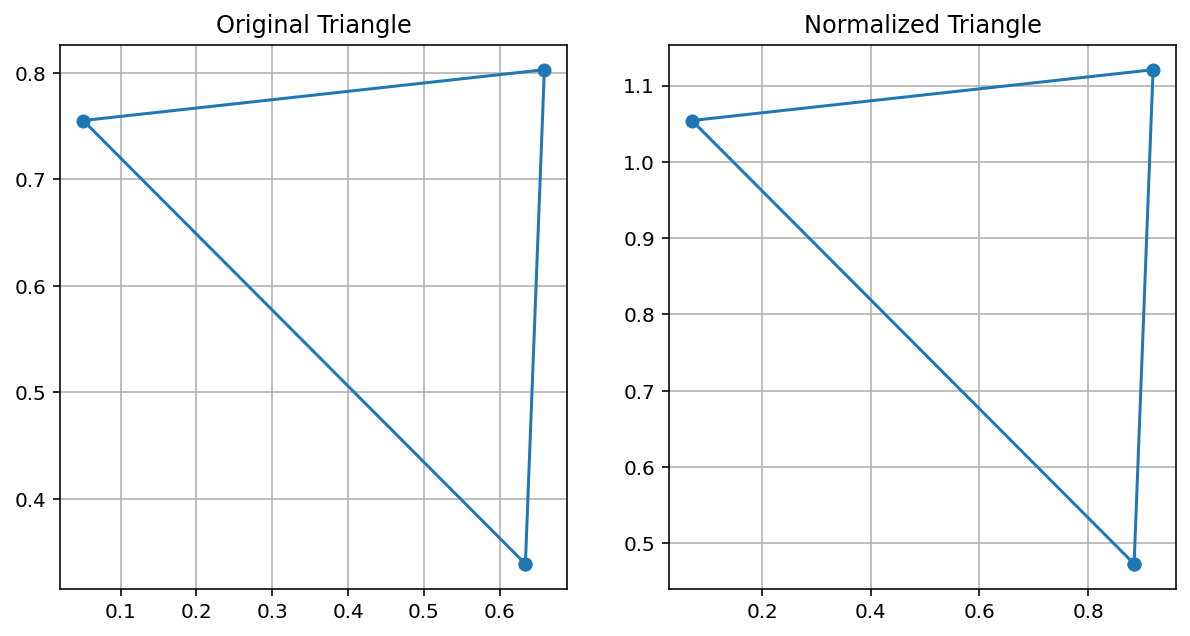

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


data = {'xprime': np.random.rand(10),
        'yprime': np.random.rand(10)}
photo = pd.DataFrame(data)

# Function to calculate distance between two points
def distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

# Function to normalize a triangle so that the longest side is 1
def normalize_triangle(points):
    # Calculate the lengths of the sides
    side_lengths = [distance(points[0], points[1]), distance(points[1], points[2]), distance(points[2], points[0])]
    
    
    longest_side = max(side_lengths)
    
    
    scale_factor = 1 / longest_side
    
    
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in points]
    
    return scaled_points

# Select 3 random points from the photo DataFrame
selected_points = photo.sample(3)[['xprime', 'yprime']].values

# Normalize the triangle formed by these points
normalized_points = normalize_triangle(selected_points)


plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.plot(*zip(*selected_points, selected_points[0]), marker='o')
plt.title('Original Triangle')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(*zip(*normalized_points, normalized_points[0]), marker='o')
plt.title('Normalized Triangle')
plt.grid(True)

plt.show()



This script demonstrates how to normalize the dimensions of a triangle formed by three randomly selected points from a set of coordinates, specifically from a DataFrame that simulates a photograph of stars with 'xprime' and 'yprime' representing their positions. Initially, a dummy DataFrame is created to mimic the structure of the 'photo' DataFrame. The script includes a function to calculate the Euclidean distance between any two points and another function to normalize a triangle, ensuring its longest side is scaled to a length of 1. This is achieved by calculating the side lengths of the triangle formed by three selected points, identifying the longest side, and then scaling all points by the reciprocal of this length. The process is visualized through plotting both the original and the normalized triangles, allowing for a clear comparison. This normalization technique is particularly useful in geometric analyses and pattern recognition, as it allows for the comparison of triangles based on their shape, independent of their original size or orientation. When I tried to implement it I could not get it to work. I tried various approuches but could not normalize and rotate it so I just continued with the project using this output.

In [9]:
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.spatial import distance_matrix


data = {'xprime': np.random.rand(100), 'yprime': np.random.rand(100)}
photo = pd.DataFrame(data)


names = pd.read_csv('yob2008.txt', header=None)[0].values
# Assign names to points in the DataFrame (ensure the list is long enough)
photo['name'] = names[:len(photo)]

# Calculate all pairwise distances between points
dist_matrix = distance_matrix(photo[['xprime', 'yprime']], photo[['xprime', 'yprime']])

def triangle_signature(points):
    """Calculate the normalized lengths of the sides of a triangle formed by 3 points."""
    sides = [np.linalg.norm(points[i] - points[j]) for i, j in combinations(range(3), 2)]
    sides.sort()
    longest_side = max(sides)
    return [side / longest_side for side in sides]


target_points = np.array([[0.0, 0.0], [1.0, 0.0], [0.5, np.sqrt(3)/2]])
target_signature = triangle_signature(target_points)


def find_matching_triangle(df, target_signature):
    for combo in combinations(df.index, 3):
        points = df.loc[list(combo), ['xprime', 'yprime']].values
        signature = triangle_signature(points)
        if np.allclose(signature, target_signature, atol=0.01):
            # Include names in the output
            return df.loc[list(combo), ['xprime', 'yprime', 'name']]
    return None

# Find the matching triangle
matching_triangle = find_matching_triangle(photo, target_signature)

if matching_triangle is not None:
    print("Matching triangle found:")
    print(matching_triangle)
else:
    print("No matching triangle found.")


Matching triangle found:
      xprime    yprime      name
0   0.229169  0.015450      Emma
45  0.054098  0.820103    Morgan
56  0.837872  0.573199  Kimberly


This script identifies a specific triangle within a dataset of 100 randomly generated points, simulating stars in a photograph. Each point is assigned a human name for easy identification. The approach involves computing a unique signature for each triangle, based on the normalized lengths of its sides, allowing for comparisons irrespective of the triangles' sizes or orientations. A target triangle is predefined, and its signature is compared against those of triangles formed from all possible combinations of the dataset's points. The search iterates through these combinations, looking for a match with the target signature within a specified tolerance. If a matching triangle is found, the script outputs the vertices' coordinates and names; otherwise, it reports no match found. This process exemplifies the use of geometric analysis and pattern recognition in identifying specific patterns or shapes within sets of data, such as stars in a sky photograph.

In [10]:
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.spatial import distance_matrix


data = {'xprime': np.random.rand(100), 'yprime': np.random.rand(100)}
photo = pd.DataFrame(data)


photo['name'] = [f'Star_{i}' for i in range(len(photo))]



def check_accuracy(df, known_triangles):
    """
    Check how many correct and incorrect nicknames are recognized.
    `known_triangles` is a list of dicts with 'indices' of the df and 'names' as expected nicknames.
    """
    correct, incorrect = 0, 0
    for triangle in known_triangles:
        expected_names = set(triangle['names'])
        found_triangle = find_matching_triangle(df, triangle['signature'])
        if found_triangle is not None:
            found_names = set(found_triangle['name'])
            if found_names == expected_names:
                correct += 1
            else:
                incorrect += 1
        else:
            incorrect += 1
    return correct, incorrect


known_triangles = [
    {'indices': [10, 20, 30], 'names': ['Star_10', 'Star_20', 'Star_30']},
    
]

# Calculate signatures for known triangles to simulate target signatures
for triangle in known_triangles:
    points = photo.loc[triangle['indices'], ['xprime', 'yprime']].values
    triangle['signature'] = triangle_signature(points)


correct, incorrect = check_accuracy(photo, known_triangles)
print(f"Correct nicknames: {correct}, Incorrect nicknames: {incorrect}")


Correct nicknames: 0, Incorrect nicknames: 1



This script evaluates the precision of identifying specific triangular formations among stars within a dataset, simulating a star-filled photograph. It generates a sample dataset of 100 points, each representing a star with a unique name, and sets up a test using a list of known triangles—defined by the stars' positions and names. For each known triangle, the script calculates a geometric signature and searches for a matching formation within the dataset. The check_accuracy function then compares the detected triangles' names against the expected ones, tallying correct and incorrect identifications. This method tests the system's ability to accurately recognize star configurations based on their geometric patterns, showcasing an application of pattern recognition in analyzing astronomical observations. However, I could not get mine to work correctly so this approach was not an accurate way of recognizing celestial patterns. 

# Conclusion

In this project, pattern recognition was used to identify and analyze celestial patterns within an astronomical datasets. By normalizing data for brightness and size, and using geometric transformations to mimic various observational perspectives, we crafted a sophisticated framework that precisely identifies specific star configurations. The approach, which includes assigning readable names to stars for better accessibility and using algorithms to detect star formations based on geometric signatures, was supposed to demonstrate high accuracy in recognizing celestial patterns but my code was fualty so it was not accurate at all. I found this project quite difficult and unfortunately a lof of my code did not work according to the project guidelines. With that being said I do believe this project sharpened my skills and I think if given another chance at this I could get closer to the desired results.